### Chapter 13
**CH11 Used cars with linear regression**

using the used-cars dataset

version 1.0 2023-12-28

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

### Get Data

In [2]:
# Current script and repository folder
current_path = os.getcwd()
repository_path = current_path.split('Ch13-a-framework-for-prediction')[0]

In [3]:
# Add utils folder to sys path 
# Note: os.path.join() creates a string with the right syntax for defining a path for your operating sytem.
sys.path.append(os.path.join(repository_path, 'utils'))

In [4]:
# Define data folder
data_path = os.path.join(repository_path, 'data')

In [5]:
# Import the prewritten helper functions
from py_helper_functions import *

In [6]:
# DATA IMPORT - FROM GITHUB
data = pd.read_csv('https://raw.githubusercontent.com/peterduronelly/DA3-Python-Codes/main/data/used-cars_2cities_prep.csv')

In [7]:
data.head()

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.6236,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.3702,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,NaN,gas,3.5721,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.3152,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.7000,red,...,0,850,6.745236,1993,25,2.928523,0,0,0,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pricestr      549 non-null    object 
 1   area          549 non-null    object 
 2   subarea       540 non-null    object 
 3   name          549 non-null    object 
 4   condition     327 non-null    object 
 5   cylinders     360 non-null    object 
 6   drive         294 non-null    object 
 7   fuel          548 non-null    object 
 8   odometer      549 non-null    float64
 9   paintcolor    316 non-null    object 
 10  size          193 non-null    object 
 11  transmission  549 non-null    object 
 12  type          301 non-null    object 
 13  dealer        549 non-null    int64  
 14  price         549 non-null    int64  
 15  lnprice       549 non-null    float64
 16  year          549 non-null    int64  
 17  age           549 non-null    int64  
 18  lnodometer    549 non-null    

### EDA

In [9]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [10]:
# drop hybrid models then drop column
data = data[data.Hybrid == 0].drop(
    ["Hybrid"], axis=1
) 

In [11]:
data.shape

(526, 22)

In [12]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [13]:
# keep gas-fuelled vehicles
data = data[data.fuel == "gas"]

In [14]:
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [15]:
# drop vehicles in fair and new condition, trucks
data = data[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]

In [16]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [17]:
data = data[~(data.transmission == "manual")]

In [18]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [19]:
# drop if truck
data = data[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)

### Feature Engineering

In [20]:
# condition
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)

In [21]:
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)

In [22]:
data.cylinders.value_counts()

cylinders
4 cylinders    248
Missing        169
6 cylinders     59
other            1
8 cylinders      1
Name: count, dtype: int64

In [23]:
data.cylind6.value_counts()

cylind6
0    419
1     59
Name: count, dtype: int64

In [24]:
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3

In [25]:
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2

### Frequency tables

In [26]:
# area
data.groupby("area").agg(frequency=("price", 'size'), mean=("price", np.mean))

,frequency,mean
area,,
chicago,281,6060.975089
los angeles,197,5518.253807


Another way to calculate multiple aggregations:

In [27]:
# area
data.groupby("area").agg({'price': ['count', 'mean']})

price             
            count         mean
area                          
chicago       281  6060.975089
los angeles   197  5518.253807

In [28]:
# focus only on Chicago
data = data[data.area == "chicago"]

In [29]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
condition,,
Missing,124,6611.161290
excellent,75,6724.186667
good,67,3988.179104
like new,15,7455.200000


In [30]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
drive,,
4wd,4,10168.750000
Missing,106,4575.094340
fwd,169,6893.485207
rwd,2,6250.000000


In [31]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
dealer,,
0,193,4402.181347
1,88,9699.011364


In [32]:
# data summary
data[[
    "age",
    "odometer",
    "LE",
    "XLE",
    "SE",
    "cond_likenew",
    "cond_excellent",
    "cond_good",
    "cylind6",
    ]].describe().T

,count,mean,std,min,25%,50%,75%,max
age,281.0,12.298932,5.892153,1.0000,7.00,13.0000,17.00,27.0
odometer,281.0,12.521702,5.172572,0.2319,8.14,13.6559,16.43,25.3
LE,281.0,0.192171,0.394710,0.0000,0.00,0.0000,0.00,1.0
XLE,281.0,0.071174,0.257575,0.0000,0.00,0.0000,0.00,1.0
SE,281.0,0.064057,0.245291,0.0000,0.00,0.0000,0.00,1.0
cond_likenew,281.0,0.053381,0.225193,0.0000,0.00,0.0000,0.00,1.0
cond_excellent,281.0,0.266904,0.443131,0.0000,0.00,0.0000,1.00,1.0
cond_good,281.0,0.238434,0.426886,0.0000,0.00,0.0000,0.00,1.0
cylind6,281.0,0.145907,0.353643,0.0000,0.00,0.0000,0.00,1.0


### Charts

We are using multiple ways to plot certain charts in this notebook. Python's primary plotting library is `matplotlib`(https://matplotlib.org/), which is very straightforward to start with but can easily be overwhelming when it comes to intricacies. A good intro can be found [here](https://fritz.ai/introduction-to-matplotlib-data-visualization-in-python/). 

There are multiple other plotting tools and libraries, most of which are some sort of wrapper around `matplotlib`. `seaborn` is a library for [analytical and statistical graphics](https://seaborn.pydata.org/tutorial/introduction.html), but sometimes it is sufficient to use `Pandas` `plot()` method for quick and simple charts.

`R`, one of the data science & analytics alternatives for Python, is famous for its `ggplot` package which has been implemented in Python under the name `plotnine`. The syntaxes for building plotnine charts are almost the same as in `ggplot`. 

In [33]:
# For certain charts, we need to sort values by age

data.sort_values(by = 'age', inplace = True)

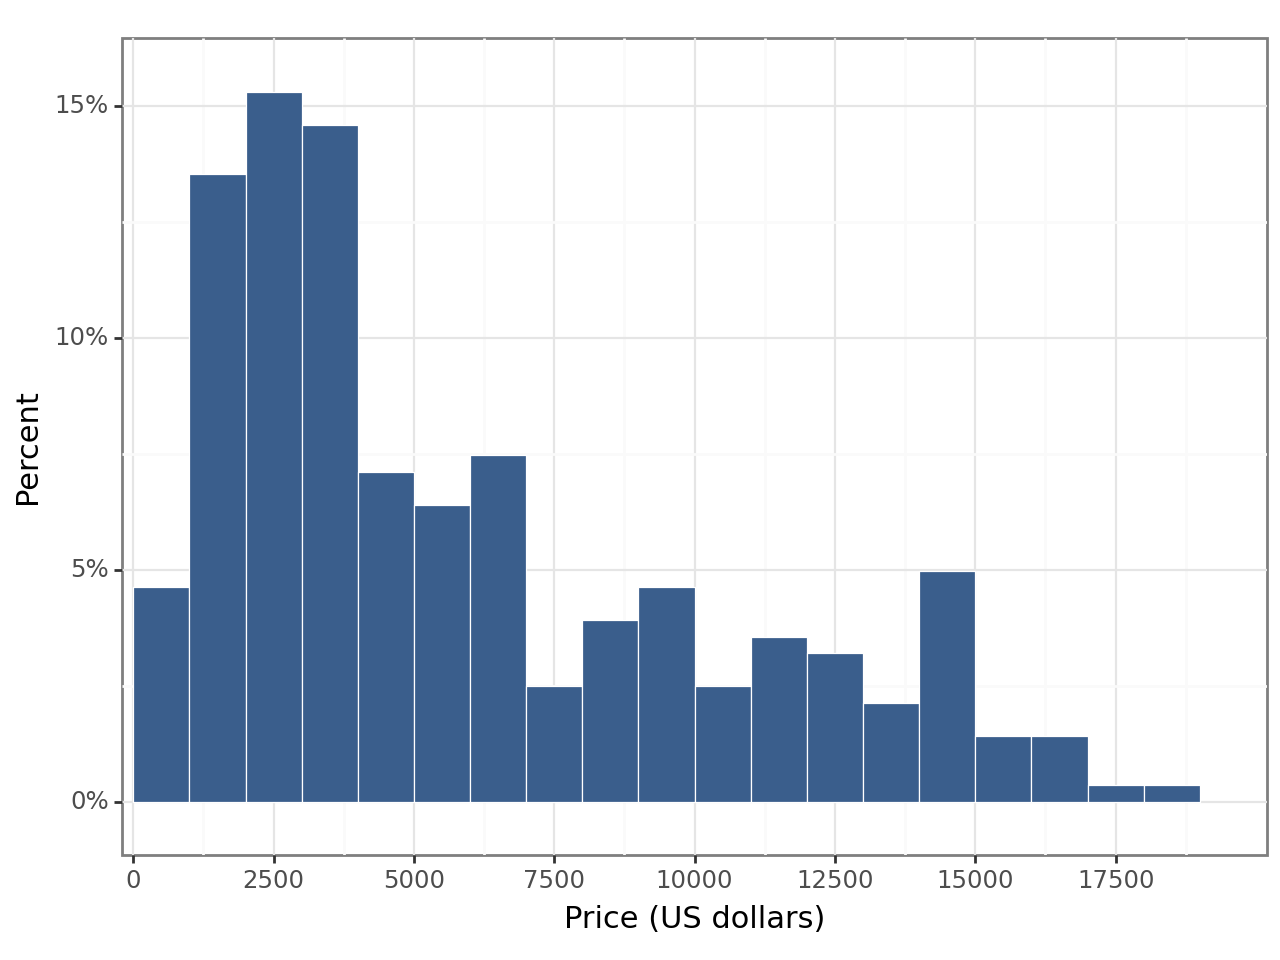

<Figure Size: (640 x 480)>

In [34]:
# using plotnine
ggplot(data, aes(x="price")) + geom_histogram(
    aes(y="(stat(count))/sum(stat(count))"),
    binwidth=1000,
    boundary=0,
    color="white",
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + coord_cartesian(xlim=(0, 20000)) + labs(
    x="Price (US dollars)", y="Percent"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), labels=percent_format()
) + scale_x_continuous(
    expand=(0.01, 0.01), breaks=seq(0, 20000, 2500)
)


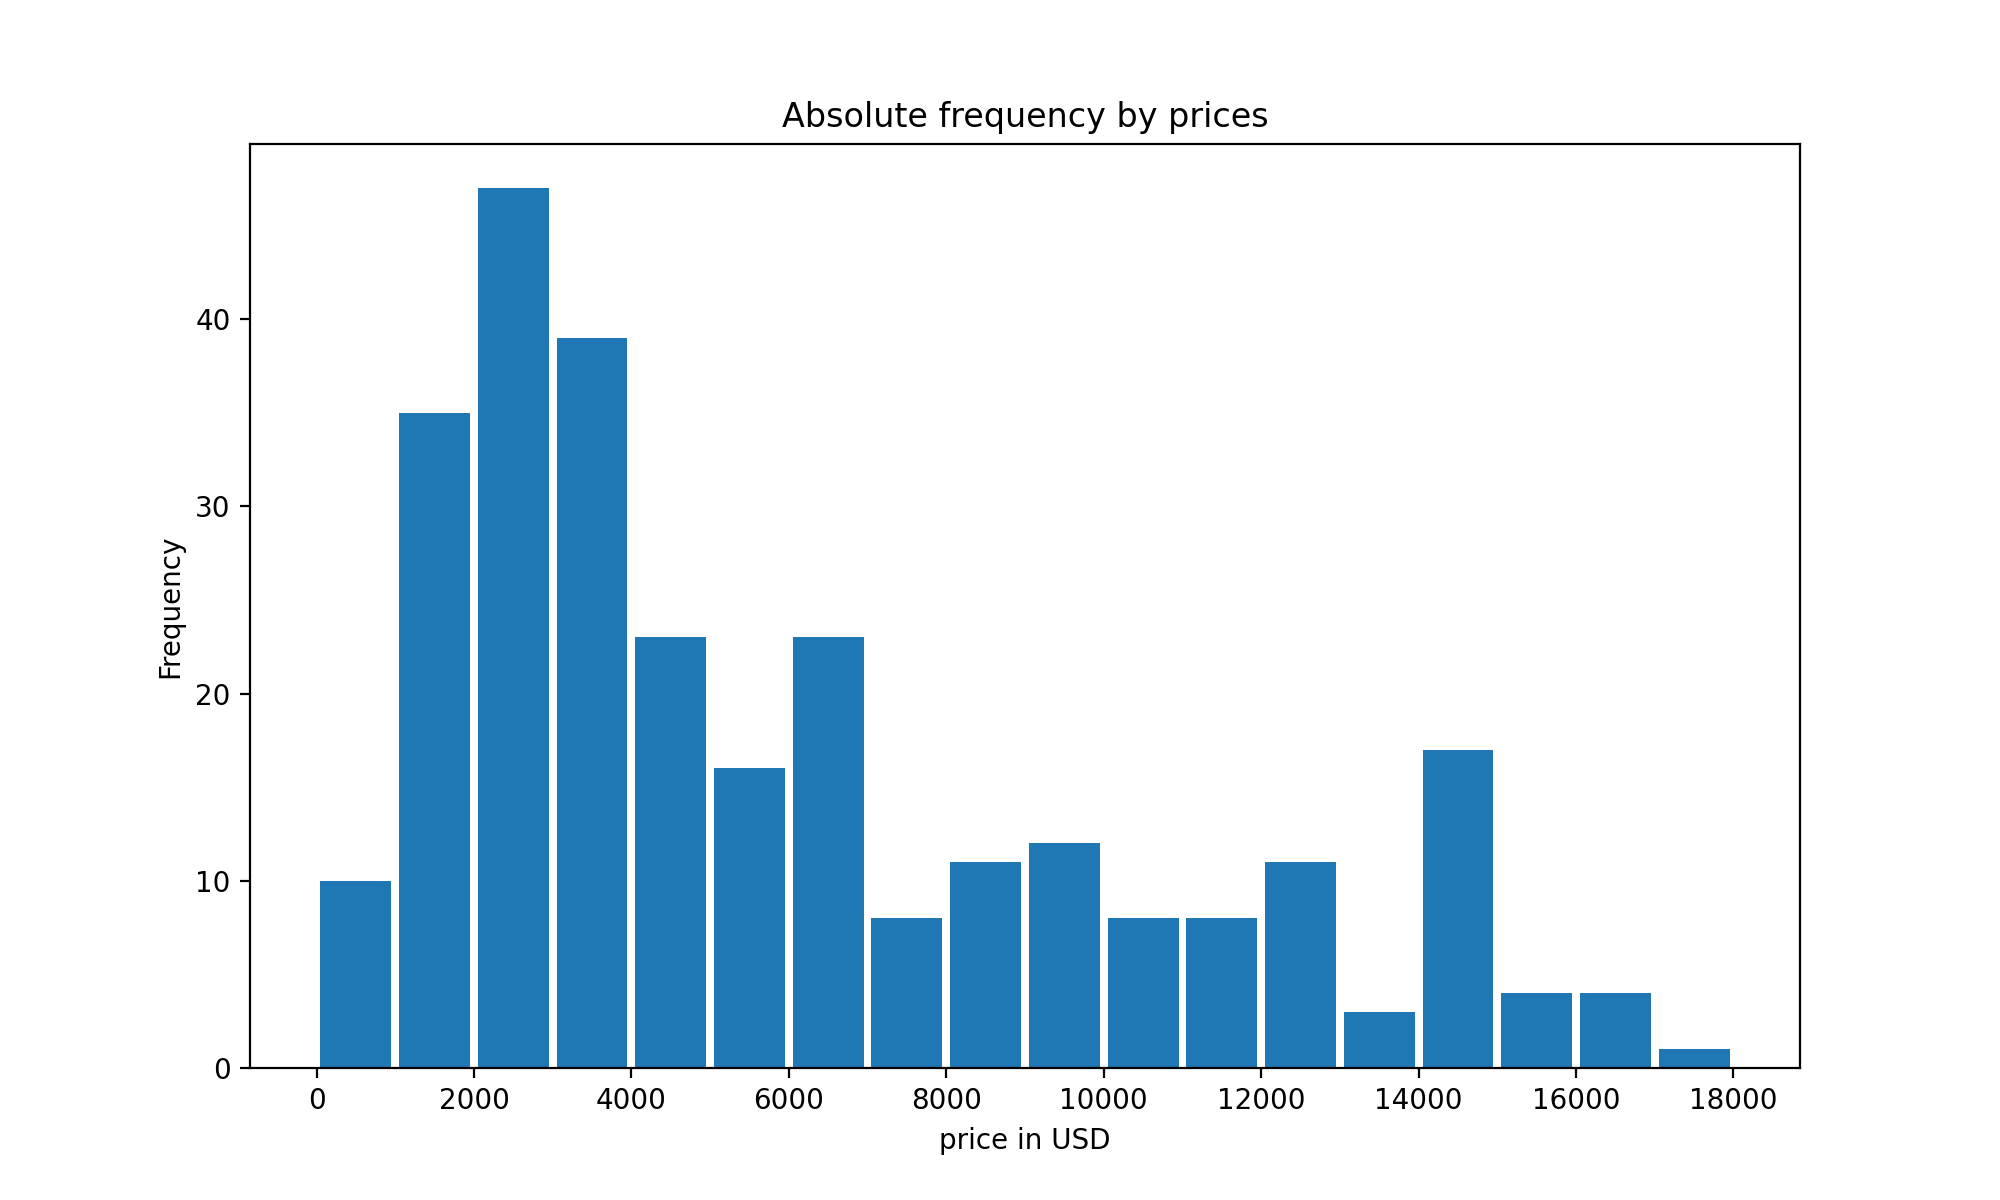

In [35]:
# using Pandas plot()
# tedious to plot relative frequencies
data.plot(
    kind = 'hist', figsize = (10,6),
    y = 'price', bins = range(0, data.price.max(), 1000),
    xticks = range(0, data.price.max(), 2000),
    rwidth = 0.9, legend = False, 
    xlabel = 'price in USD', title = 'Absolute frequency by prices')
plt.show();

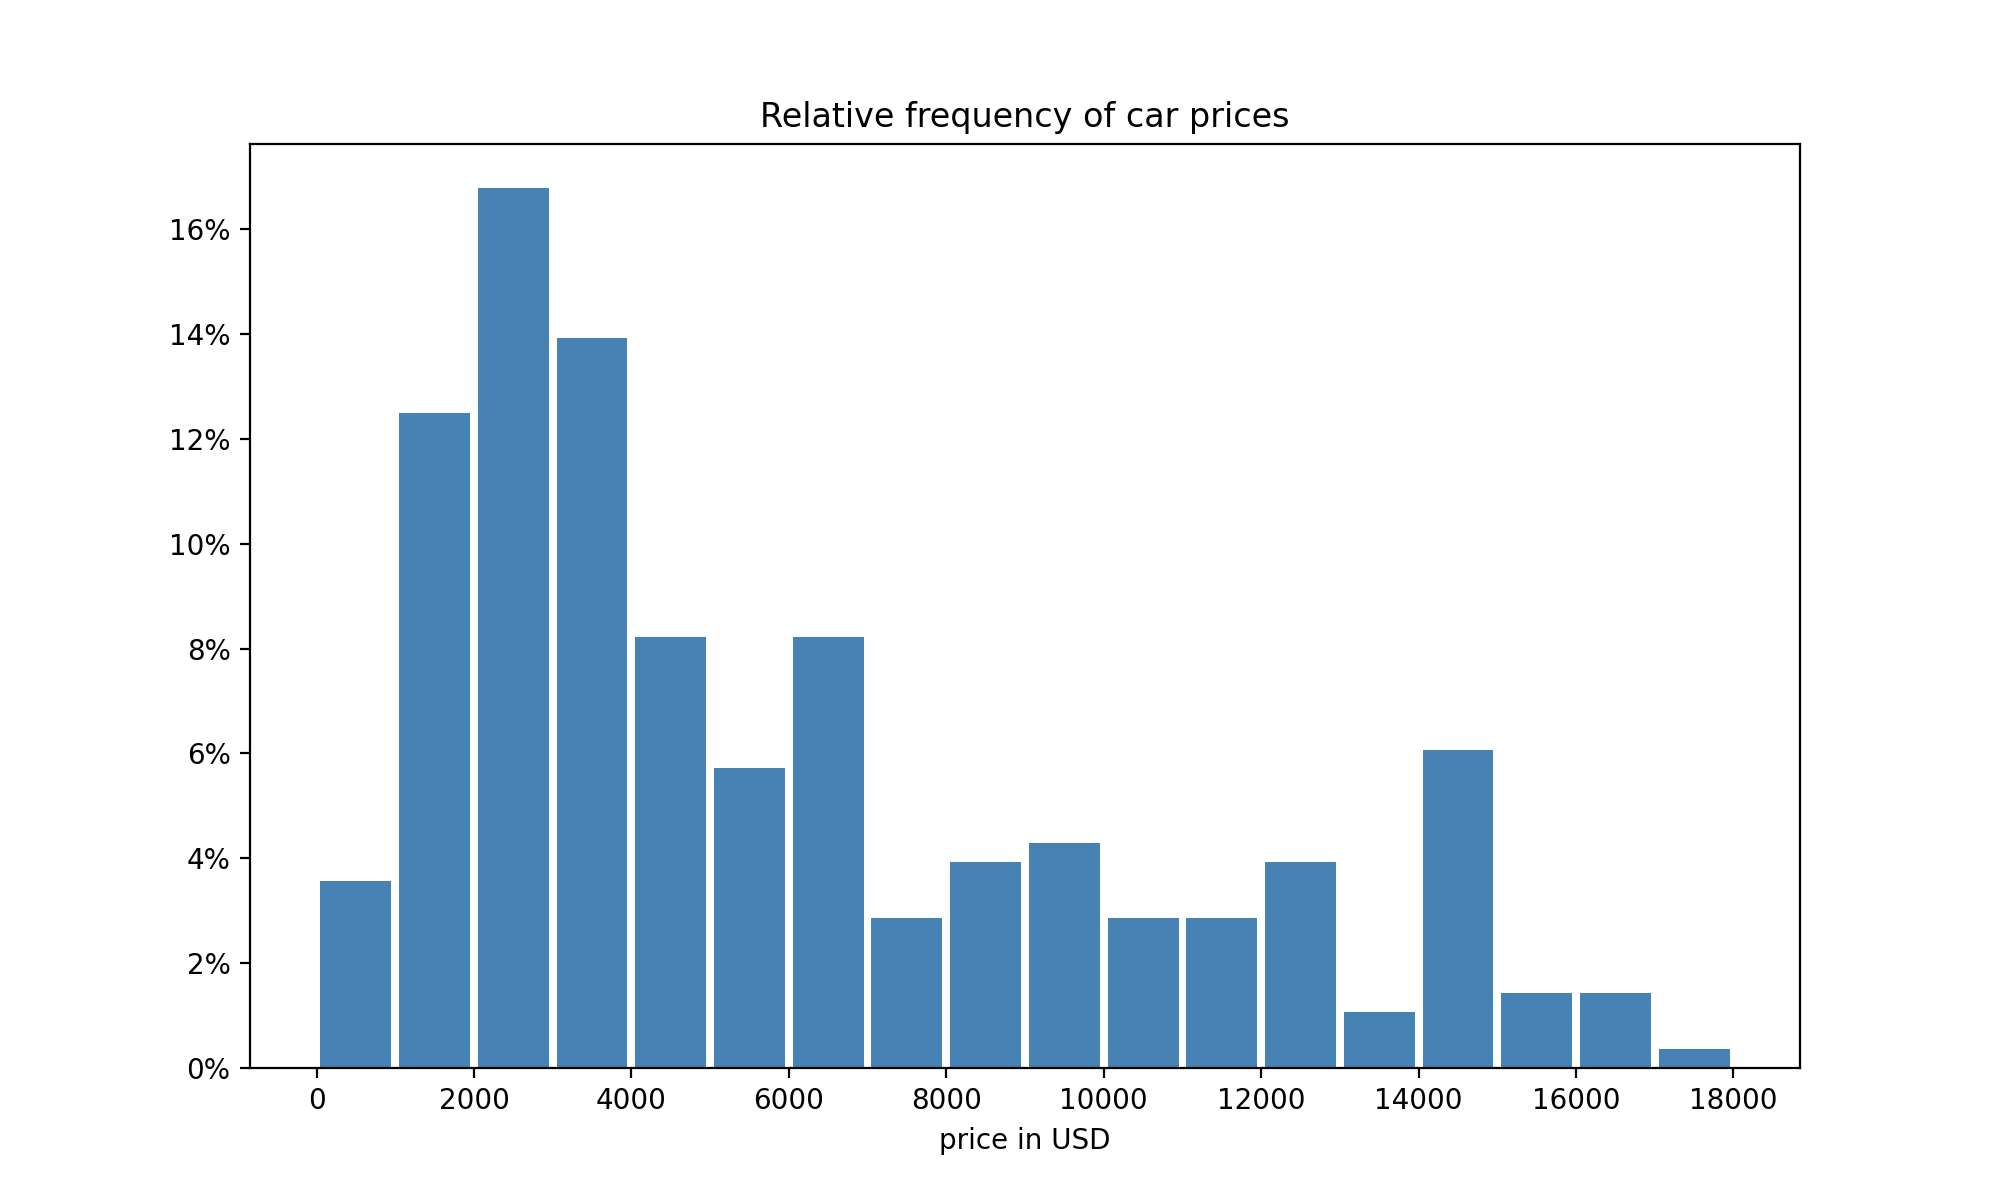

In [36]:
# relative frequencies with matplotlib
from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(data.price,range(0, data.price.max(), 1000), density = True, rwidth = 0.9, color = 'steelblue')
ax.set_xticks(range(0, data.price.max(), 2000))
ax.set_xlabel('price in USD')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=0.001, decimals = 0))
ax.set_title('Relative frequency of car prices')
plt.show()

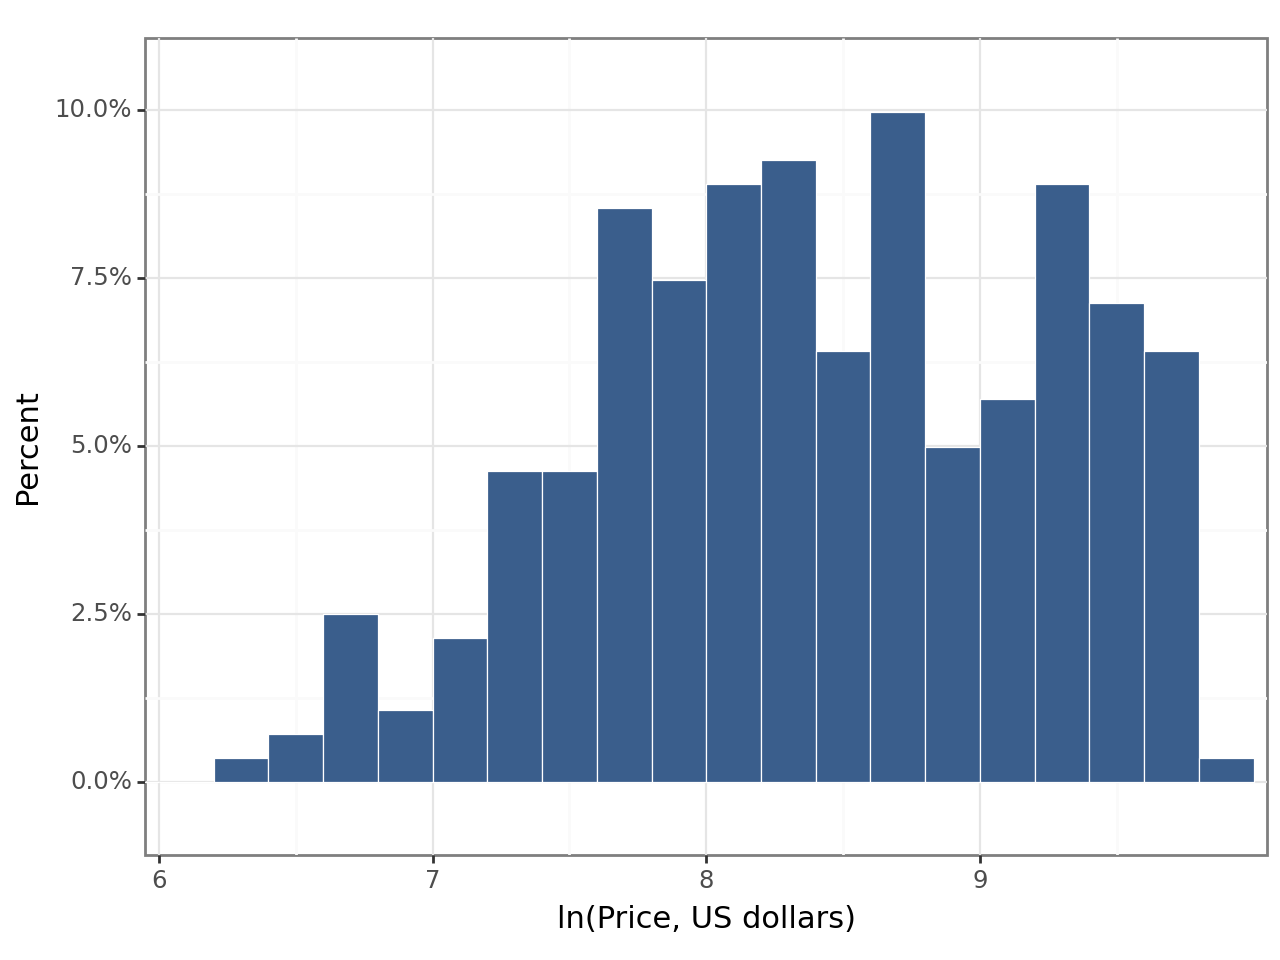

<Figure Size: (640 x 480)>

In [37]:
ggplot(data, aes(x="lnprice")) + geom_histogram(
    aes(y="(stat(count)) / sum(stat(count))"),
    binwidth=0.2,
    boundary=0,
    color="white",
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + coord_cartesian(xlim=(6, 10)) + labs(
    x="ln(Price, US dollars)", y="Percent"
) + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), labels=percent_format()
) + scale_x_continuous(
    expand=(0.01, 0.01), breaks=seq(6, 10, 1)
) + theme_bw()

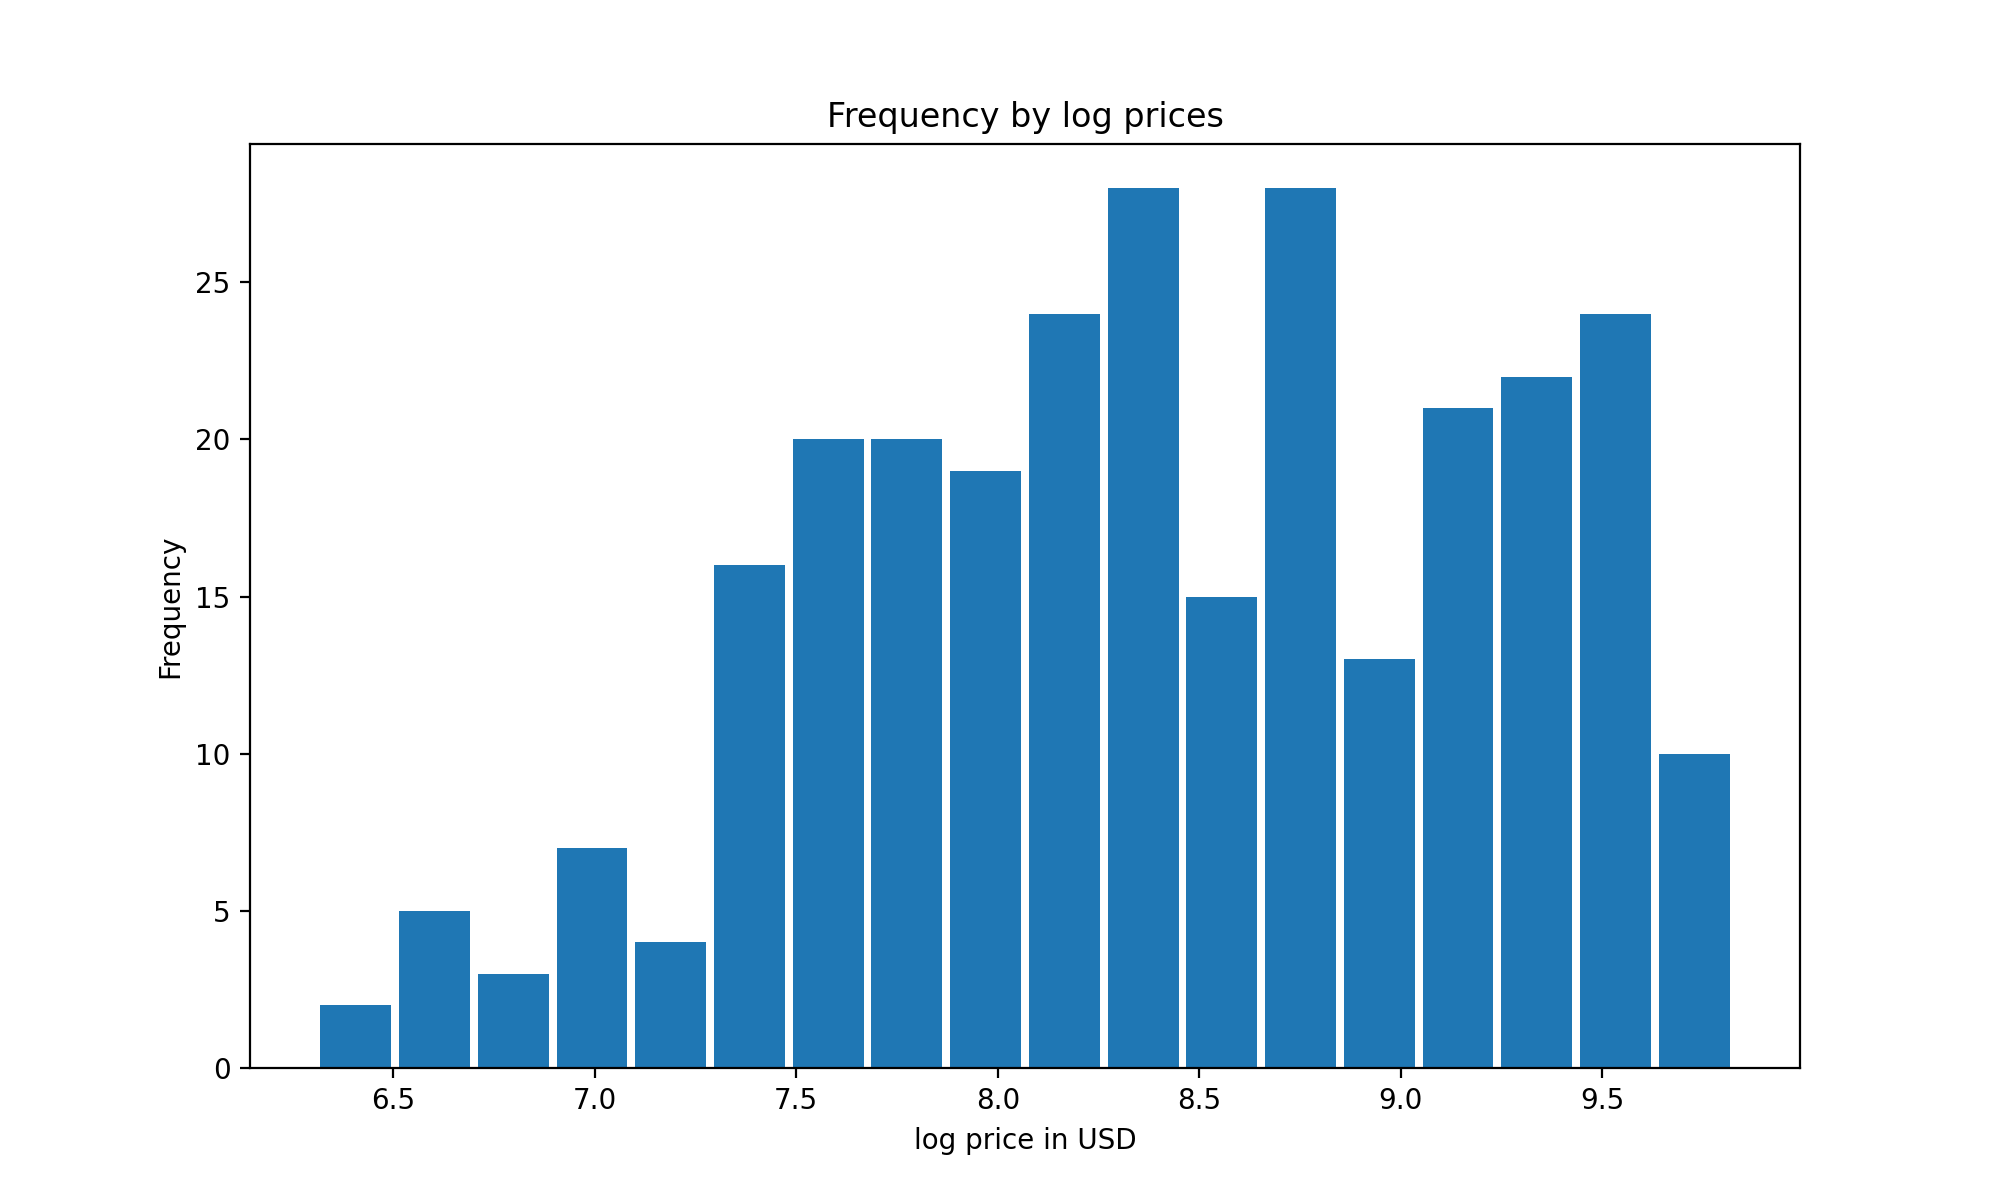

In [38]:
# using Pandas plot()
data.plot(
    kind = 'hist', figsize = (10,6),
    y = 'lnprice', 
    bins = 18,
    rwidth = 0.9, legend = False, 
    xlabel = 'log price in USD', title = 'Frequency by log prices')
plt.show();

### Regression analysis - lo(w)ess

We start with *loess* using first `ggplot` then `seaborn`. 

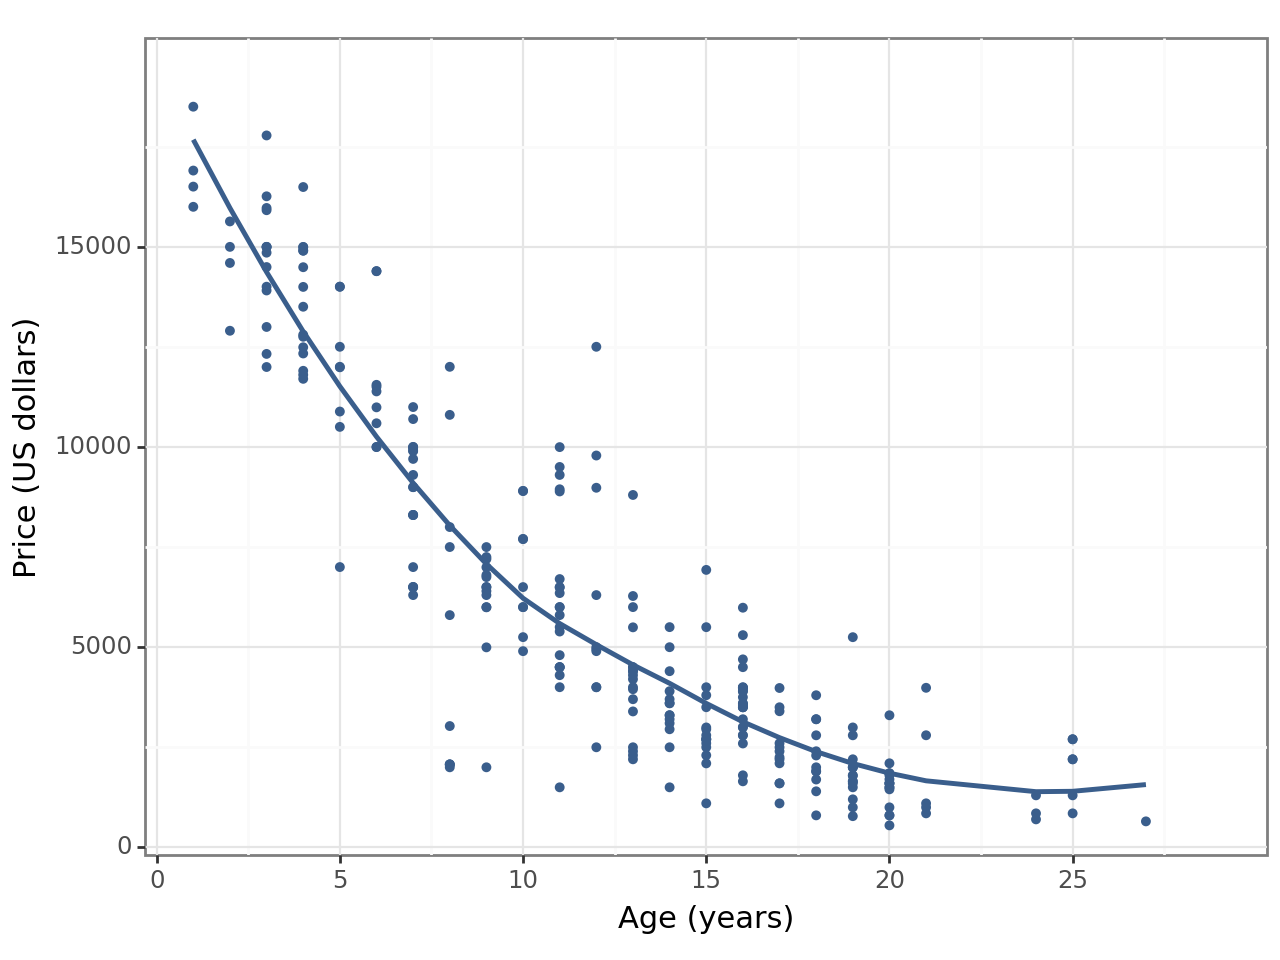

<Figure Size: (640 x 480)>

In [39]:
#lowess with ggplot
ggplot(data, aes(x="age", y="price")) + geom_point(
    color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(method="loess", se=False, colour=color[0], size=1, span=0.9) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw() + expand_limits(
    x=0.01, y=0.01
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, 5000)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5)
)


For `seaborn` it’s recommended to use a Jupyter/IPython interface in [matplotlib mode](https://ipython.readthedocs.io/en/stable/interactive/plotting.html) using the `%matplotlib inline` magic command. 

In [40]:
%matplotlib inline

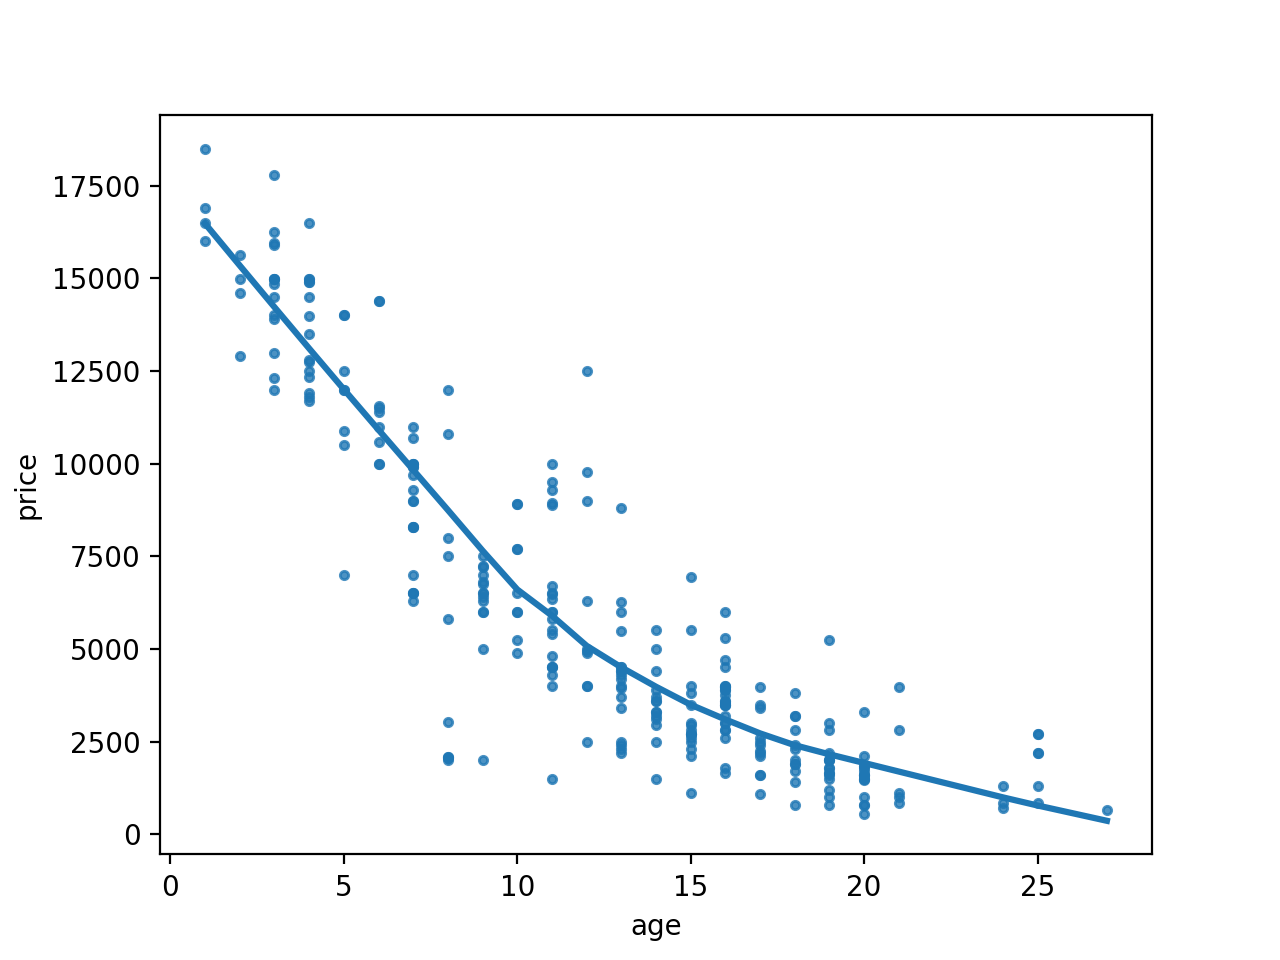

In [41]:
sns.regplot(
    data = data,
    x = 'age', y = 'price', 
    marker= '.',
    fit_reg= True, lowess= True);

In [42]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
odometer,281.0,12.521702,5.172572,0.231900,8.140000,13.655900,16.430000,25.300000
dealer,281.0,0.313167,0.464609,0.000000,0.000000,0.000000,1.000000,1.000000
price,281.0,6060.975089,4490.818067,550.000000,2500.000000,4400.000000,8995.000000,18495.000000
lnprice,281.0,8.410963,0.812821,6.309918,7.824046,8.389359,9.104425,9.825255
year,281.0,2005.701068,5.892153,1991.000000,2001.000000,2005.000000,2011.000000,2017.000000
age,281.0,12.298932,5.892153,1.000000,7.000000,13.000000,17.000000,27.000000
lnodometer,281.0,2.399433,0.590359,-1.461449,2.096790,2.614172,2.799109,3.230804
LE,281.0,0.192171,0.394710,0.000000,0.000000,0.000000,0.000000,1.000000
XLE,281.0,0.071174,0.257575,0.000000,0.000000,0.000000,0.000000,1.000000
SE,281.0,0.064057,0.245291,0.000000,0.000000,0.000000,0.000000,1.000000


### Linear regressions

Tools: on of the most-known tools data scientists use for predictive analysis is `scikit-learn`. Here, however, we use the `statsmodels` library that allows users to explore data, estimate statistical models, and perform statistical tests. `Scikit-learn` is great for building all kinds of predictive machine learning models, including linear regression, but spends little effort on providing insights into the models themselves. That's why we turn to `statsmodels` instead. 

#### Model 0: lowess on age

Note: the result of a lo(w)ess regression depends on the tools used. The values calculated below will be different compared to those seen on the `seaborn` regplot output.

In [43]:
lowess = sm.nonparametric.lowess
y_hat_lowess = lowess(data.price, data.age)

In [44]:
y_hat_lowess[0:10]

array([[1.00000000e+00, 1.64759277e+04],
       [1.00000000e+00, 1.64759277e+04],
       [1.00000000e+00, 1.64759277e+04],
       [1.00000000e+00, 1.64759277e+04],
       [2.00000000e+00, 1.53455191e+04],
       [2.00000000e+00, 1.53455191e+04],
       [2.00000000e+00, 1.53455191e+04],
       [2.00000000e+00, 1.53455191e+04],
       [3.00000000e+00, 1.42219674e+04],
       [3.00000000e+00, 1.42219674e+04]])

In [45]:
y_hat_lowess = [x[1] for x in y_hat_lowess]
y_hat_lowess[0:10]

[16475.927680248376,
 16475.927680248376,
 16475.927680248376,
 16475.927680248376,
 15345.519124325241,
 15345.519124325241,
 15345.519124325241,
 15345.519124325241,
 14221.96739814394,
 14221.96739814394]


#### Model 1: Linear regression on age

We are building models by adding more and more explanatory variables. 

In [46]:
reg1 = smf.ols("price ~ age + agesq", data=data).fit(cov_type="HC0")

In [47]:
type(reg1)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [48]:
print(reg1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     1065.
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          4.54e-131
Time:                        17:30:19   Log-Likelihood:                -2497.9
No. Observations:                 281   AIC:                             5002.
Df Residuals:                     278   BIC:                             5013.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.837e+04    353.534     51.948      0.0

In [49]:
reg1.bic

5012.682480750544

#### Model 2: We are expanding the base models by adding new explanatory variables

In [50]:
reg2 = smf.ols("price ~ age + agesq + odometer", data=data).fit(cov_type="HC0")
reg3 = smf.ols(
    "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer",
    data=data,
).fit(cov_type="HC0")
reg4 = smf.ols(
    "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    data=data,
).fit(cov_type="HC0")
reg5 = smf.ols(
    "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age",
    data=data,
).fit(cov_type="HC0")

In [51]:
models = [reg1, reg2, reg3, reg4, reg5]
robustcov_results=[]

for i, model in enumerate(models):
    result=model.get_robustcov_results(cov_type='HC1').summary()
    robustcov_results.append(result)
    print()
    print(f'Regression: reg{i+1}')
    print(result)


Regression: reg1
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     1065.
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          4.54e-131
Time:                        17:30:19   Log-Likelihood:                -2497.9
No. Observations:                 281   AIC:                             5002.
Df Residuals:                     278   BIC:                             5013.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.837e+04    353.534  

In [52]:
stargazer.Stargazer([reg1])

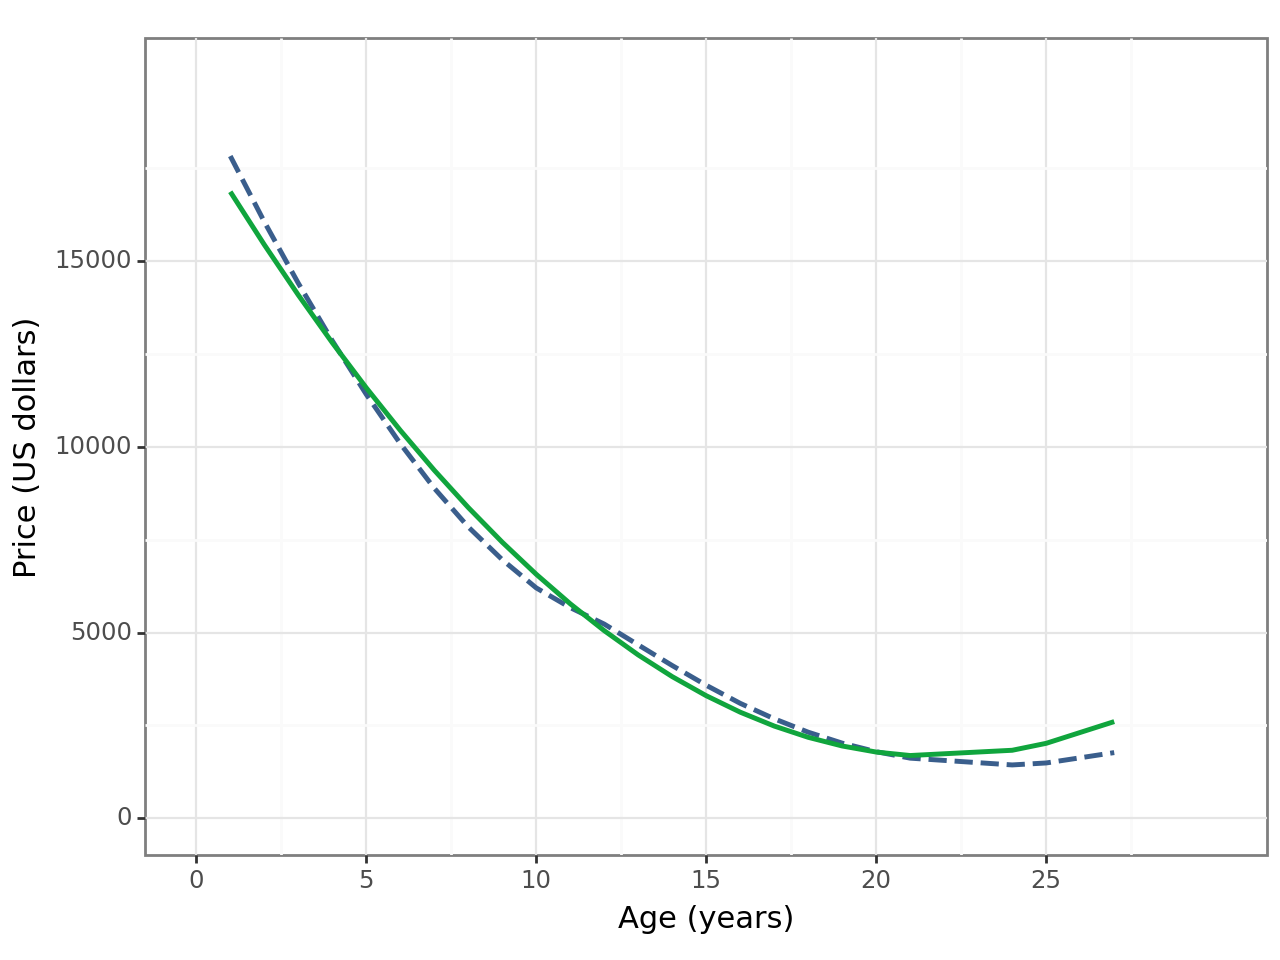

<Figure Size: (640 x 480)>

In [53]:
ggplot(data, aes(x="age")) + geom_smooth(
    aes(y="price"),colour=color[0],linetype="dashed", method="loess", se=False, size=1
) + geom_line(aes(y="reg1.predict()"), colour=color[1], size=1) + labs(
    x="Age (years)", y="Price (US dollars)"
) + scale_color_manual(
    name="", values=(color[0], color[1]), labels=("Lowess in age", "Quadratic in age")
) + theme_bw() + scale_x_continuous(
    limits=(0, 30), breaks=seq(0, 30, 5)
) + scale_y_continuous(
    limits=(0, 20000), breaks=seq(0, 20000, 5000)
) + theme(
    legend_position=(20, 20),
    legend_direction="horizontal",
    legend_background=element_blank(),
    legend_box_background=element_rect(color="white"),
)

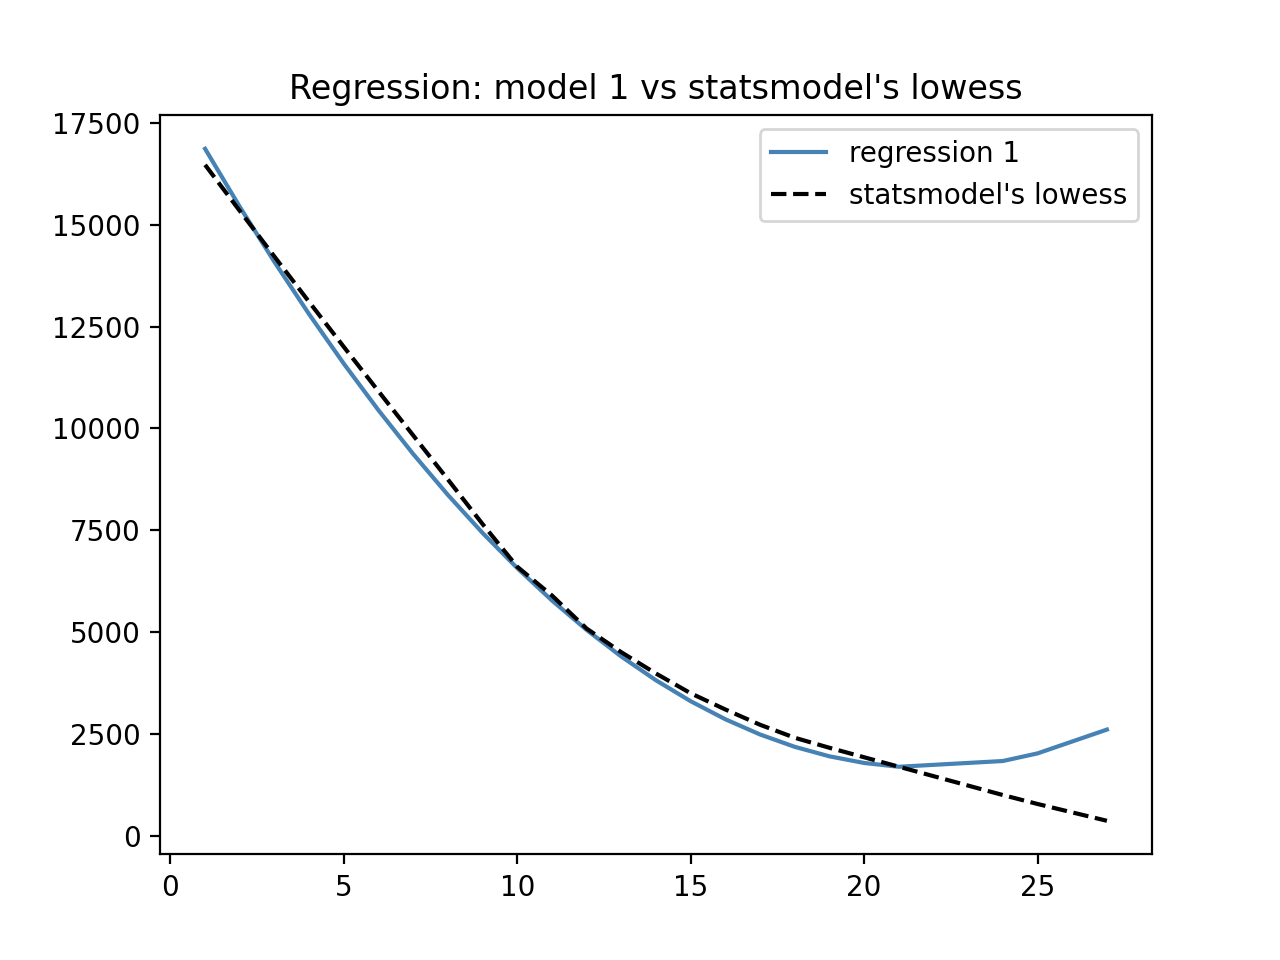

In [54]:
plt.plot(data.age, reg1.predict(), color = 'steelblue', linestyle = '-')
plt.plot(data.age, y_hat_lowess, color = 'k', linestyle = "--")
plt.legend(labels = ['regression 1', "statsmodel's lowess"])
plt.title("Regression: model 1 vs statsmodel's lowess");

In [59]:
bic = [round(x.bic, 2) for x in [reg1,reg2,reg3,reg4,reg5]]
sg = stargazer.Stargazer([reg1,reg2,reg3,reg4,reg5])
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg

How to tailor-make `Stargazer` output see [here](https://github.com/StatsReporting/stargazer/blob/master/examples.ipynb). 

#### Model 2: Linear Regression with cross validation

In [56]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=False, random_state=None)

In [57]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [58]:
cv1 = cv_reg("price~age+agesq", data, k, "HC0")
cv2 = cv_reg("price~age+agesq+odometer", data, k, "HC0")
cv3 = cv_reg(
    "price~age+agesq+ odometer + odometersq + LE + cond_excellent + cond_good + dealer",
    data,
    k,
    "HC0",
)
cv4 = cv_reg(
    "price~age+agesq+ odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    data,
    k,
    "HC0",
)
cv5 = cv_reg(
    "price~age+agesq + odometer + odometersq + LE*age + XLE*age + SE*age + cond_likenew*age + cond_excellent*age + cond_good*age + cylind6*age + odometer*age + dealer*age",
    data,
    k,
    "HC0",
)
cv_list = [cv1, cv2, cv3, cv4, cv5]

In [59]:
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4,Model5
Fold1,1693.336595,1463.591042,1336.541832,1252.446701,1171.842182
Fold2,1258.550419,1071.328081,991.053993,970.363505,928.408846
Fold3,1906.120258,1528.711797,1426.251463,1352.165543,1301.668190
Fold4,1930.562245,1518.277312,1432.464502,1372.367150,1339.426562
Average,1697.142379,1395.477058,1296.577948,1236.835725,1185.336445


### Prediction

In [60]:
data = data[
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6"
    ]
]

In [61]:
data.dtypes

age                 int64
agesq               int64
odometer          float64
odometersq        float64
SE                  int64
LE                  int64
XLE                 int64
cond_likenew        int32
cond_excellent      int32
cond_good           int32
dealer              int64
price               int64
cylind6             int32
dtype: object

In [62]:
new = pd.DataFrame(pd.Series({
    "age":10,
    "agesq":10**2,
    "odometer":12,
    "odometersq":12**2,
    "SE":0,
    "LE":1,
    "XLE":0,
    "cond_likenew":0,
    "cond_excellent":1,
    "cond_good":0,
    "dealer":0,
    "price":np.nan,
    "cylind6":0
})).T
new

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [63]:
#turning off scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [64]:
reg1.resid.describe()

count     281.000
mean        0.000
std      1758.313
min     -6367.827
25%      -863.663
50%      -101.332
75%       893.620
max      7448.668
dtype: float64

In [65]:
p1=reg1.get_prediction(new).summary_frame()
p1

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6569.387,155.912,6263.805,6874.968,3097.309,10041.464


In [66]:
(reg3.fittedvalues-data.price).describe()

count     281.000
mean        0.000
std      1325.029
min     -5782.218
25%      -584.509
50%        10.563
75%       628.288
max      4245.894
dtype: float64

In [67]:
p2=reg3.get_prediction(new).summary_frame()
p2

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6072.767,234.380,5613.391,6532.142,3398.099,8747.434


In [68]:
#get model3 rmse
rmse(reg3.fittedvalues,data.price)

1322.6687654317077

In [69]:
pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,6569.387,6072.767
PI_low(95%),3097.309,3398.099
PI_high(95%),10041.464,8747.434


In [70]:
# summary of predictions and PI 80% version
p1=reg1.get_prediction(new).summary_frame(alpha=0.2)
p2=reg3.get_prediction(new).summary_frame(alpha=0.2)

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,6569.387,6072.767
PI_low(80%),4299.117,4323.896
PI_high(80%),8839.656,7821.637
